<a href="https://colab.research.google.com/github/CodingPenguins/ML3/blob/main/Copy_of_ML3_Week6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doctor, there is something wrong with my potato!  
## Image classification of potato leave diseases using CNN

## Motivation and Introduction

After working solely on different penguin related environmental data sets for both modules on supervised and unsupervised learning, I originally intended to wrap up this module on the basis of image classification of penguins - the former as I was interested in working more in detail on another data type, and not again preformated, tabulated data, the latter for obvious reasons... :)

However, the Environmental Data Analysis platform does not provide suitable images, and finding images of other species easily accessible without deep domain knowledge (and usable without licencing!) lead me to the dataset titled "Potato Plant Diseases Data" provided here:


    Hafiz Nouman:
    🌱 Potato Plant Diseases Data 🍂
    Comprehensive Dataset for Identifying and Classifying Potato Plant Diseases,
    https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
    (Accessed 2024-06-18).


It was only uploaded last year (Version 2: 2024-05-28, with the original upload being 3 days older) to Kaggle Datasets (and is not a Kaggle Project!) and thus is a rather fresh dataset. The data was also released into the Public Domain by the author! So it promises to be a good starting point for image classification using Deep Learning.

The dataset itself consists of 2152 images in JPG format, of single plucked potato leaves photographed in front of a static background in varying rotations. 1000 images are categorised as being affected by early blight, further 1000 images are categorised as being affected by late blight, and further 152 images are provided depicting healthy potato leaves.

For some background: Early blight (EB) is caused by Alternaria solani (https://en.wikipedia.org/wiki/Alternaria_solani), a fungus, while late blight (LB) is caused by Phytophthora infestans (https://en.wikipedia.org/wiki/Phytophthora_infestans), which is an oomycete (a fungus-like microorganism). Late blight was one of the main causes of history's well-known potato famines.

The project will set the following aims:
- Building a Convolutional Neural Network to correctly classify whether a leaf is healthy, or shows symptoms of EB or LB.
- After an initial model is built, optimizing this model through hyperparameter tuning
- To go beyond the scope of the models we have seen in class, an Involutional Neural Network will be implemented for comparison. The code will be taken from https://keras.io/examples/vision/involution/.
- Afterwards, comparison with a simple neural network utilizing one hidden, dense layer, trained on the extracted length x width x depth matrices should be performed
- Evaluating which model is best suited for image classification of potato diseases

## EDA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#import keras
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall, AUC, MeanSquaredError
from keras.utils import image_dataset_from_directory
from keras.losses import SparseCategoricalCrossentropy
import cv2
from google.colab.patches import cv2_imshow #Workaround provided by Google Colab, as cv2_imshow is suppressed
import pandas as pd
import shutil #For moving files in Google Drive
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics
from keras.utils import set_random_seed

The dataset has been loaded into my Google Drive. In case you want to replicate this notebook, the data loaded was Version 2 of the dataset as discussed above.

In [ ]:
path_all = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/"

In [ ]:
path_eb = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_Early_blight/"
path_lb = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_Late_blight/"
path_h = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_healthy/"

Let us take a look at a sample data file of a healthy potato plant's leaf, as well as a represenative of EB and LB:

In [ ]:
sample_h = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"
sample_eb = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG"
sample_lb = "/content/drive/MyDrive/ColabNotebooks/ML-Week6/Potato_Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG"

In [ ]:
sample_image_h = cv2.imread(sample_h)
sample_array_h = np.asarray(sample_image_h,dtype = np.float64)
sample_image_eb = cv2.imread(sample_eb)
sample_array_eb = np.asarray(sample_image_eb,dtype = np.float64)
sample_image_lb = cv2.imread(sample_lb)
sample_array_lb = np.asarray(sample_image_lb,dtype = np.float64)

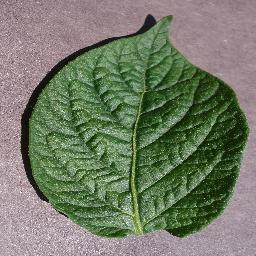

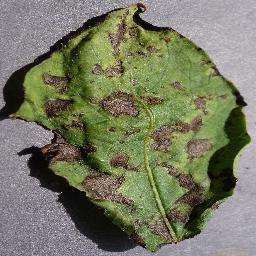

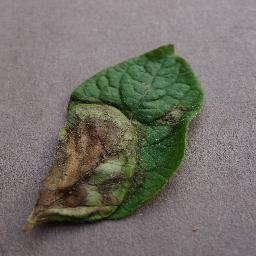

In [ ]:
cv2_imshow(sample_image_h)
cv2_imshow(sample_image_eb)
cv2_imshow(sample_image_lb)

Already looking at the three example photos, we get a good first impression of the similarities and characteristic features between the classes, as well as possible challenges: We see that leaves are provided in various lighting and background conditions, thereby creating shadow effects (see particular image of EB). The leaves are not of the same age and saturation with chlorophyll (compare unaffected leave parts of EB with unaffected parts of LB). In addition, sizes and rotations as well as textures differ.

However, we see that all leaves are provided with a static (although differing) background, with a uniformly applied grainy texture, and in isolation of other objects.

Regarding the features, we see the characteristic bulls-eye pattern of EB, creating spotted appearences on the leaf, while LB has a more continuously appearing patch shape with a surrounding damaged leaf structure. Of course, we do expect these to differ in their stages.

In [ ]:
print("Shape of a healty leaf image: ", sample_array_h.shape)
print("Shape of a healty leaf image: ", sample_array_eb.shape)
print("Shape of a healty leaf image: ", sample_array_lb.shape)

Shape of a healty leaf image:  (256, 256, 3)
Shape of a healty leaf image:  (256, 256, 3)
Shape of a healty leaf image:  (256, 256, 3)


In [ ]:
different_format_count_h = 0
different_format_count_eb = 0
different_format_count_lb = 0
for item in os.listdir(path_h):
  temp = cv2.imread(path_h + item)
  temp_array = np.asarray(temp,dtype = np.float64)
  if temp_array.shape == (256,256,3):
    different_format_count_h += 1

for item in os.listdir(path_eb):
  temp = cv2.imread(path_eb + item)
  temp_array = np.asarray(temp,dtype = np.float64)
  if temp_array.shape == (256,256,3):
    different_format_count_eb += 1

for item in os.listdir(path_lb):
  temp = cv2.imread(path_lb + item)
  temp_array = np.asarray(temp,dtype = np.float64)
  if temp_array.shape == (256,256,3):
    different_format_count_lb += 1


In [ ]:

print("There are ", 152-different_format_count_h, ", ", 1000-different_format_count_eb, ", and ", 1000-different_format_count_lb, " images not having a format of (256,256,3)")

There are  0 ,  0 , and  0  images not having a format of (256,256,3)


Ok, so all images are all taken with the same format, that is re-assuring. Now, how about the image content? Let's start again with the sample images:

In [ ]:
sample_array_h[0,0,]

array([147., 140., 161.])

In [ ]:
sample_array_eb[0,0,]

array([127., 120., 123.])

In [ ]:
sample_array_lb[0,0,]

array([138., 134., 145.])

Well, the first background pixel's RGB value looks similar enough, but that is just one random pixel of arbitrarily selected images. Let us load the array information for every image and store it in a dataframe.

In [ ]:
df_h = pd.DataFrame((os.listdir(path_h)), columns = ["ImageName"])
df_h[["ImagePath"]] = path_h
df_h[["ImageContent"]] = None
df_h[["LeafClass"]] = "h"

df_eb = pd.DataFrame((os.listdir(path_eb)), columns = ["ImageName"])
df_eb[["ImagePath"]] = path_eb
df_eb[["ImageContent"]] = None
df_eb[["LeafClass"]] = "eb"

df_lb = pd.DataFrame((os.listdir(path_lb)), columns = ["ImageName"])
df_lb[["ImagePath"]] = path_lb
df_lb[["ImageContent"]] = None
df_lb[["LeafClass"]] = "lb"

In [ ]:
df_eb

,ImageName,ImagePath,ImageContent,LeafClass
0,0caf6a39-3f5f-4201-a4d7-3ea35fdf1303___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
1,0a0744dc-8486-4fbb-a44b-4d63e6db6197___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
2,05c35093-11b8-4cd0-b67a-148859754440___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
3,0bbb8bce-2020-416b-8bd6-c160c2db9921___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
4,0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
...,...,...,...,...
995,cd025ad0-9486-4ee6-b545-c9040dc4e1c7___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
996,f8b57e69-5902-4253-8404-11811ecf13e8___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
997,e40b6718-52b6-46a7-970c-5f1b6bae23af___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb
998,f8b3542b-559a-4aa4-9f4a-ec4d22f4386f___RS_Earl...,/content/drive/MyDrive/ColabNotebooks/ML-Week6...,None,eb


In [ ]:
for i in range(0,df_h.shape[0]):
  df_h["ImageContent"][i] = np.asarray(cv2.imread(df_h["ImagePath"][i] + df_h["ImageName"][i]))

In [ ]:
for i in range(0,df_eb.shape[0]):
  df_eb["ImageContent"][i] = np.asarray(cv2.imread(df_eb["ImagePath"][i] + df_eb["ImageName"][i]))

In [ ]:
for i in range(0,df_lb.shape[0]):
  df_lb["ImageContent"][i] = np.asarray(cv2.imread(df_lb["ImagePath"][i] + df_lb["ImageName"][i]))

In [ ]:
df_all = pd.concat([df_h, df_eb, df_lb])

In [ ]:
(df_all).shape

(2152, 4)

In [ ]:
(df_h["ImageContent"]).head()

,ImageContent
0,"[[[170, 170, 176], [169, 169, 175], [169, 169,..."
1,"[[[143, 135, 152], [130, 122, 139], [149, 141,..."
2,"[[[146, 142, 161], [156, 152, 171], [156, 152,..."
3,"[[[143, 137, 156], [147, 141, 160], [143, 137,..."
4,"[[[173, 169, 188], [169, 165, 184], [183, 179,..."


In [ ]:
h_average = 0
h_avg_channel = [0,0,0]

for item in df_h["ImageContent"]:
  h_average += np.average(item)
  h_avg_channel += np.average(item, axis = (0,1))
h_average = h_average / df_h["ImageContent"].shape[0]
h_avg_channel = h_avg_channel / df_h["ImageContent"].shape[0]
print("Pixel average of healthy images is: ")
print(h_average)
print("Average channels of healthy images are: ")
print(h_avg_channel)

Pixel average of healthy images is: 
123.22763185333788
Average channels of healthy images are: 
[112.41655189 132.4195909  124.84675277]


array([[[146, 142, 161],
        [156, 152, 171],
        [156, 152, 171],
        ...,
        [161, 157, 176],
        [152, 148, 167],
        [165, 161, 180]],

       [[125, 121, 140],
        [144, 140, 159],
        [165, 161, 180],
        ...,
        [157, 153, 172],
        [150, 146, 165],
        [163, 159, 178]],

       [[137, 133, 152],
        [148, 144, 163],
        [165, 161, 180],
        ...,
        [135, 131, 150],
        [133, 129, 148],
        [145, 141, 160]],

       ...,

       [[196, 190, 207],
        [149, 143, 160],
        [169, 163, 180],
        ...,
        [166, 161, 176],
        [168, 163, 178],
        [177, 172, 187]],

       [[179, 173, 190],
        [130, 124, 141],
        [156, 150, 167],
        ...,
        [187, 182, 197],
        [181, 176, 191],
        [173, 168, 183]],

       [[145, 139, 156],
        [167, 161, 178],
        [180, 174, 191],
        ...,
        [209, 204, 219],
        [194, 189, 204],
        [166, 161, 176]]], dtype=uint8)
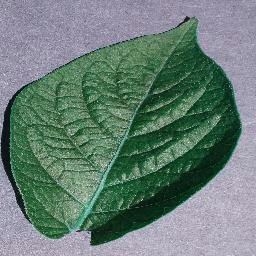

In [ ]:
df_h["ImageContent"][2]

In [ ]:
eb_average = 0
eb_avg_channel = [0,0,0]
for item in df_eb["ImageContent"]:
  eb_average += np.average(item)
  eb_avg_channel += np.average(item, axis = (0,1))
eb_average = eb_average / df_eb["ImageContent"].shape[0]
eb_avg_channel = eb_avg_channel / df_eb["ImageContent"].shape[0]
print("Pixel average of EB images is: ")
print(eb_average)
print("Average channels of EB images are: ")
print(eb_avg_channel)

Pixel average of EB images is: 
131.1041074574789
Average channels of EB images are: 
[115.36930898 141.22959053 136.71342287]


array([[[160, 141, 133],
        [147, 128, 120],
        [149, 130, 122],
        ...,
        [101,  77,  79],
        [109,  85,  85],
        [100,  76,  76]],

       [[157, 138, 130],
        [138, 119, 111],
        [132, 113, 105],
        ...,
        [101,  77,  79],
        [104,  80,  80],
        [106,  82,  82]],

       [[166, 147, 139],
        [154, 135, 127],
        [148, 129, 121],
        ...,
        [ 99,  77,  79],
        [ 96,  75,  74],
        [100,  79,  78]],

       ...,

       [[186, 167, 164],
        [188, 169, 166],
        [191, 172, 169],
        ...,
        [111,  95,  96],
        [111,  95,  96],
        [138, 122, 123]],

       [[191, 172, 169],
        [191, 172, 169],
        [192, 173, 170],
        ...,
        [135, 119, 120],
        [134, 118, 119],
        [140, 124, 125]],

       [[193, 174, 171],
        [192, 173, 170],
        [190, 171, 168],
        ...,
        [114,  98,  99],
        [106,  90,  91],
        [110,  94,  95]]], dtype=uint8)
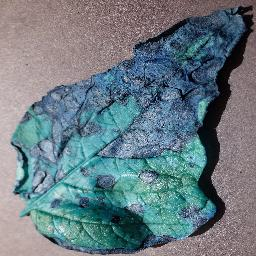

In [ ]:
df_eb["ImageContent"][2]

In [ ]:
lb_average = 0
lb_avg_channel = [0,0,0]
for item in df_lb["ImageContent"]:
  lb_average += np.average(item)
  lb_avg_channel += np.average(item, axis = (0,1))
lb_average = lb_average / df_lb["ImageContent"].shape[0]
lb_avg_channel = lb_avg_channel / df_lb["ImageContent"].shape[0]
print("Pixel average of LB images is: ")
print(lb_average)
print("Average channels of LB images are: ")
print(lb_avg_channel)

Pixel average of LB images is: 
113.91154545593237
Average channels of LB images are: 
[104.71503636 119.2819557  117.7376443 ]


array([[[177, 158, 161],
        [172, 153, 156],
        [169, 150, 153],
        ...,
        [145, 126, 141],
        [122, 103, 118],
        [120, 101, 116]],

       [[180, 161, 164],
        [176, 157, 160],
        [174, 155, 158],
        ...,
        [136, 117, 132],
        [ 99,  80,  95],
        [150, 131, 146]],

       [[179, 160, 163],
        [178, 159, 162],
        [177, 158, 161],
        ...,
        [112,  93, 108],
        [112,  93, 108],
        [173, 154, 169]],

       ...,

       [[178, 164, 170],
        [198, 184, 190],
        [186, 172, 178],
        ...,
        [128, 116, 134],
        [127, 115, 133],
        [106,  94, 112]],

       [[140, 126, 132],
        [171, 157, 163],
        [166, 152, 158],
        ...,
        [147, 135, 153],
        [121, 109, 127],
        [ 62,  50,  68]],

       [[183, 169, 175],
        [192, 178, 184],
        [186, 172, 178],
        ...,
        [114, 102, 120],
        [141, 129, 147],
        [110,  98, 116]]], dtype=uint8)
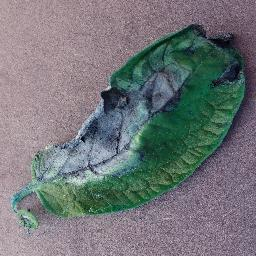

In [ ]:
df_lb["ImageContent"][2]

So, it does look like the average pixel value is lowest for LB, and highest in EB, with healthy images in the middle. However, there is a lot of variety in the images (as seen by the further examples plotted above), so that is not much help. The average channels also look somewhat distinguishing for each item - but without taking into account region information, this would most likely not be enough for predicting either label (we will see whether this assessment is correct when predicting using the flattened data in a NN with one deep layer later).

Can we do anything else in the framework of pre-processing? We can quickly verify our categories are intact by plotting them in a histgram:

(array([ 152.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

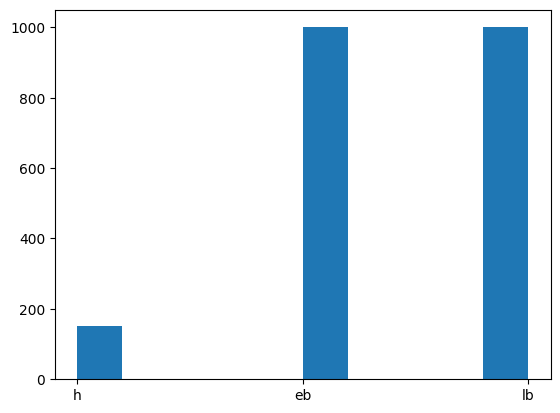

In [ ]:
plt.hist(df_all["LeafClass"])

No surprise here... We should however keep in mind that the data is heavily biased towards either leaf pathology. To avoid Type-I errors, we should keep a look at a score that can help us identify imbalances. Precision/Recall could be helpful, or directly obtaining the FPR.
We could also increase our healthy leaf image data by generating copies with simple image operations, such as mirroring along the central vertical/horizontal axis, rotation, etc. However, depening on the model we use, we might overtrain on certain aspects of the images, rendering it less useful for real-world deployment.

In any case, since the libraries we use provide a lot of this functionality already built in, we do not have to deal with topics of image processing (or, as we have loaded matrices, matrix operations), but we need to keep in mind to pass these later.

# Model training

To reproduce the results below, we set a random seed. However, there is still some degree in randomness when training Keras models, and rendering these calculations deterministic will have a negative impact on the runtime. So executing the code below will produce varying results still.

In [ ]:
set_random_seed(123)

So, to start, we need to generate a dataset respecting the labels from the directories. We can use Keras' image_dataset_from_directory for this, letting it handle the labels by inferring these from the directory structure. We chose 10% as hold out for the validation.

In [ ]:
batch_size = 24

In [ ]:
img_dataset_train = image_dataset_from_directory(
    path_all,
    labels='inferred',
    validation_split = .1,
    subset = "training",
    seed = 123,
    image_size=(256, 256),
    batch_size=batch_size
)

img_dataset_test = image_dataset_from_directory(
    path_all,
    labels='inferred',
    validation_split = .1,
    subset = "validation",
    seed = 123,
    image_size=(256, 256),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.
Using 1937 files for training.
Found 2152 files belonging to 3 classes.
Using 215 files for validation.


We should also extract the class names inferred and check them for consistency:

In [ ]:
class_names = img_dataset_train.class_names
class_names

['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']

Looks good! For the model, let us try (after squashing our RGB values to a more ML friendly input, instead of values between 0 and 255) a basic CNN with two Convolutional layers followed by a pooling layer. Afterwards, we flatten, use a densely connected layer with a relu function, and a softmax accomodating for our 3 categories:

In [ ]:
model1 = Sequential()
model1.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model1.add(Conv2D(16,3,activation='relu'))
model1.add(Conv2D(16,3,activation='relu'))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(3)) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 254016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      16,257,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,260,051 (62.03 MB)

 Trainable params: 16,260,051 (62.03 MB)

 Non-trainable params: 0 (0.00 B)

As an optimizer, we start with stochastic gradient descent, and use Sparse Categorical Crossentropy as a loss function. As metrics, we choose the Accuracy to be monitored; specifically, since we have a multi-label model, we use the Sparse Categorical Accuracy. Since Precision or Recall (and thus F1 score) are defined for binary labels in Keras only, we cannot employ these - meaning that we have no easy metric to monitor classification balancing issues. But we can easily calculate them manually afterwards on the training/validation data.

In [ ]:
model1.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras"),
]

Let us start with 5 epochs

In [ ]:
epochs = 5

In [ ]:
modelfit1 = model1.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - SparseCategoricalAccuracy: 0.4357 - loss: 2.1704 - val_SparseCategoricalAccuracy: 0.4837 - val_loss: 1.8177
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - SparseCategoricalAccuracy: 0.4461 - loss: 2.0486 - val_SparseCategoricalAccuracy: 0.4837 - val_loss: 1.8177
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - SparseCategoricalAccuracy: 0.4624 - loss: 1.9415 - val_SparseCategoricalAccuracy: 0.4837 - val_loss: 1.8177
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 0.4508 - loss: 2.0182 - val_SparseCategoricalAccuracy: 0.4837 - val_loss: 1.8177
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - SparseCategoricalAccuracy: 0.4606 - loss: 1.9903 - val_SparseCategoricalAccuracy: 0.4837 - val_loss: 1.8177


That is not a good model - no need to check any other metric with an accuracy of less than .5! Two possible limitations spring to mind: Either we should really choose the softmax activation function for the last layer to work on probabilities, or we have created a bottle neck with the chosen Conv-Conv-Pool layer (less likely). Let's start with the first assumption, and introduce padding to the conv layers, to see if see any changes.

### Model 2

We'll introduce same padding to the Convolutional layers (the other options would have i. a. included to modify the number of filters or the kernel size), and see what it does.

In [ ]:
model2 = Sequential()
model2.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model2.add(Conv2D(16,3,padding="same", activation='relu'))
model2.add(Conv2D(16,3,padding="same", activation='relu'))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(3)) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      16,777,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,780,243 (64.01 MB)

 Trainable params: 16,780,243 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit2 = model2.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - SparseCategoricalAccuracy: 0.1055 - loss: 1.4421 - val_SparseCategoricalAccuracy: 0.0698 - val_loss: 1.0986
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 0.0799 - loss: 1.0986 - val_SparseCategoricalAccuracy: 0.0698 - val_loss: 1.0986
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - SparseCategoricalAccuracy: 0.0794 - loss: 1.0986 - val_SparseCategoricalAccuracy: 0.0698 - val_loss: 1.0986
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - SparseCategoricalAccuracy: 0.0831 - loss: 1.0986 - val_SparseCategoricalAccuracy: 0.0698 - val_loss: 1.0986
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - SparseCategoricalAccuracy: 0.0759 - loss: 1.0986 - val_SparseCategoricalAccuracy: 0.0698 - val_loss: 1.0986


That is even worse (and with the abyssmal accuracy we get, not getting any change points to the problem lying elsewhere).

## Model 3

Let's get back to predicting on probabilities, adding the softmax activation function to the last densily connected layer (which we considered and dropped during the model creation, as commented above for model 1).

In [ ]:
model3 = Sequential()
model3.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model3.add(Conv2D(16,3,padding="same", activation='relu'))
model3.add(Conv2D(16,3,padding="same", activation='relu'))
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      16,777,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,780,243 (64.01 MB)

 Trainable params: 16,780,243 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit3 = model3.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - SparseCategoricalAccuracy: 0.5849 - loss: 8.7806 - val_SparseCategoricalAccuracy: 0.8326 - val_loss: 0.4966
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 0.8890 - loss: 0.3250 - val_SparseCategoricalAccuracy: 0.7488 - val_loss: 0.5978
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - SparseCategoricalAccuracy: 0.9210 - loss: 0.2256 - val_SparseCategoricalAccuracy: 0.8744 - val_loss: 0.3553
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 0.9714 - loss: 0.0826 - val_SparseCategoricalAccuracy: 0.8930 - val_loss: 0.3430
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - SparseCategoricalAccuracy: 0.9975 - loss: 0.0195 - val_SparseCategoricalAccuracy: 0.8791 - val_loss: 0.3769


As it turns out, switching to a softmax activation function was key to getting the model to work - and so well that we receive a prediction accuracy of approx. 1 and 0.88, respectively, on the training and validation data set!

In [ ]:
#train_pred3 = model3.predict(img_dataset_train)
#test_pred3 = model3.predict(img_dataset_test)

Let us extract the batchwise predictions and labels from the data and gather them in two separate arrays for each of the training and testing data, respectively.

In [ ]:
pred_train3 = np.array([])
labels_train3 =  np.array([])
for x, y in img_dataset_train:
  pred_train3 = np.concatenate([pred_train3, np.argmax(model3.predict(x),axis=1)])
  #print(pred_train3)
  #print(len(pred_train3))
  #print(y.numpy())
  #print(len(y.numpy()))
  labels_train3 = np.concatenate([labels_train3, y.numpy()])

In [ ]:
m3_conf_train = confusion_matrix(y_true=labels_train3, y_pred=pred_train3)
print(m3_conf_train)

[[896   0   0]
 [  0 904   0]
 [  0   0 137]]


In [ ]:
pred_test3 = np.array([])
labels_test3 =  np.array([])
for x, y in img_dataset_test:
  pred_test3 = np.concatenate([pred_test3, np.argmax(model3.predict(x),axis=1)])
  #print(pred_train3)
  #print(len(pred_train3))
  #print(y.numpy())
  #print(len(y.numpy()))
  labels_test3 = np.concatenate([labels_test3, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


In [ ]:
m3_conf_test = confusion_matrix(y_true=labels_test3, y_pred=pred_test3)
print(m3_conf_test)

[[96  7  1]
 [ 4 92  0]
 [ 2 12  1]]


In [ ]:
viz = ConfusionMatrixDisplay(m3_conf_test, display_labels = class_names)

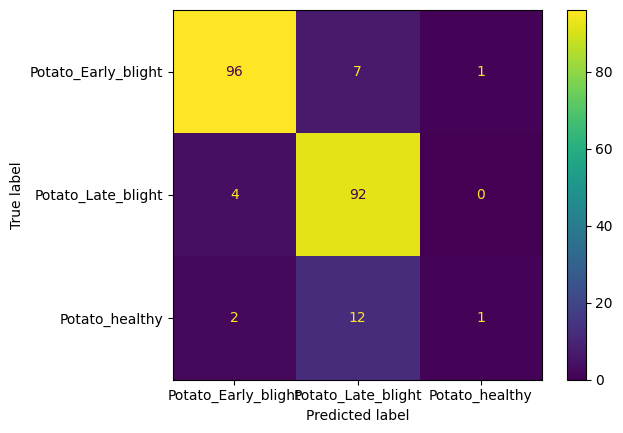

In [ ]:
viz.plot()

We do observe what could have been anticipated in view of the asymmetry of the different categories: The underrepresentated healthy potato leaves are misclassified, here as Late Blight, more often than they are correctly classified as health potato leaves.

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test3, y_pred=pred_test3, average=None)

array([0.93203883, 0.88888889, 0.11764706])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test3, y_pred=pred_test3, average=None)

array([0.94117647, 0.82882883, 0.5       ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test3, y_pred=pred_test3, average=None)

array([0.92307692, 0.95833333, 0.06666667])

With an F1 score of 0.12, we would be generating a lot of FPs when used for leaf classification. We should therefore aim at improving the model in this regard.

### Model 4

What could be done in view of the FP on the healthy leaf images? We could balance the datasets for training (this would inevitable drop the predictive accuracy in general, in particular in view of the ratio of healthy to either class (152 vs 1000!).

Another option would be to avoid overfitting, which we will try next. One option for this is to add a dropout layer to the model, which randomly sets inputs to zero (see https://keras.io/api/layers/regularization_layers/dropout/). We should apply it anywhere except for the flattening layer - a reasonable appraoch would be to use it directly before applying the flattening as an input to the fully connected layer. We'll start with dropping 20% of the inputs.

Another option we should keep in mind is that we observe a reduction in validation accuracy after epoch 4 - we could terminate the training earlier as well! (But we should not naively assume that this holds for the next model).

In [ ]:
model4 = Sequential()
model4.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model4.add(Conv2D(16,3,padding="same", activation='relu'))
model4.add(Conv2D(16,3,padding="same", activation='relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │      16,777,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,780,243 (64.01 MB)

 Trainable params: 16,780,243 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit4 = model4.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - SparseCategoricalAccuracy: 0.5738 - loss: 4.0415 - val_SparseCategoricalAccuracy: 0.8698 - val_loss: 0.3335
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - SparseCategoricalAccuracy: 0.9371 - loss: 0.2145 - val_SparseCategoricalAccuracy: 0.9209 - val_loss: 0.2140
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 0.9768 - loss: 0.0790 - val_SparseCategoricalAccuracy: 0.9488 - val_loss: 0.1411
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - SparseCategoricalAccuracy: 0.9883 - loss: 0.0357 - val_SparseCategoricalAccuracy: 0.9395 - val_loss: 0.1618
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - SparseCategoricalAccuracy: 1.0000 - loss: 0.0077 - val_SparseCategoricalAccuracy: 0.9442 - val_loss: 0.1799


So, we do not see a perfect accuracy on the training data set, but an improvement on the validation score (92.6% vs 93.0%), which would peak after epoch 4 (hence, we should assume we still overfit).

In [ ]:
pred_test4 = np.array([])
labels_test4 =  np.array([])
for x, y in img_dataset_test:
  pred_test4 = np.concatenate([pred_test4, np.argmax(model4.predict(x),axis=1)])
  labels_test4 = np.concatenate([labels_test4, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


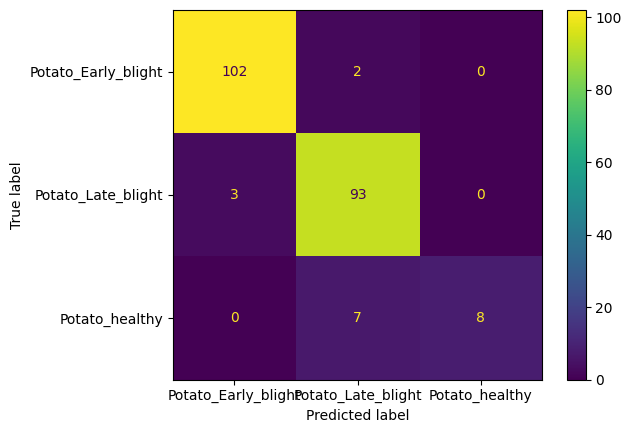

In [ ]:
m4_conf_test = confusion_matrix(y_true=labels_test4, y_pred=pred_test4)
viz = ConfusionMatrixDisplay(m4_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.97607656, 0.93939394, 0.69565217])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.97142857, 0.91176471, 1.        ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.98076923, 0.96875   , 0.53333333])

For this particular model, FP are now as frequent as correct classifications. Let's retrain the same model and stop after epoch 4.

### Model 4 - 4 Epochs only

In [ ]:
epochs = 4

In [ ]:
model4 = Sequential()
model4.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model4.add(Conv2D(16,3,padding="same", activation='relu'))
model4.add(Conv2D(16,3,padding="same", activation='relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model4.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit4 = model4.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - SparseCategoricalAccuracy: 0.5152 - loss: 4.7947 - val_SparseCategoricalAccuracy: 0.8419 - val_loss: 0.4409
Epoch 2/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - SparseCategoricalAccuracy: 0.8615 - loss: 0.3545 - val_SparseCategoricalAccuracy: 0.8558 - val_loss: 0.4530
Epoch 3/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - SparseCategoricalAccuracy: 0.9229 - loss: 0.2258 - val_SparseCategoricalAccuracy: 0.8744 - val_loss: 0.4252
Epoch 4/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - SparseCategoricalAccuracy: 0.9866 - loss: 0.0596 - val_SparseCategoricalAccuracy: 0.8837 - val_loss: 0.3235


What we do observe now is randomness effects kicking in: With no seeds set and dropping 20% of the inputs of the dropout layer, the validation accuracy is worse than in the previous run.

In [ ]:
pred_test4 = np.array([])
labels_test4 =  np.array([])
for x, y in img_dataset_test:
  pred_test4 = np.concatenate([pred_test4, np.argmax(model4.predict(x),axis=1)])
  labels_test4 = np.concatenate([labels_test4, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


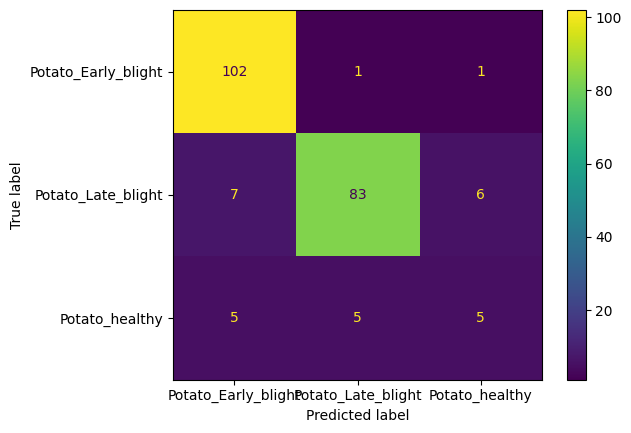

In [ ]:
m4_conf_test = confusion_matrix(y_true=labels_test4, y_pred=pred_test4)
viz = ConfusionMatrixDisplay(m4_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.93577982, 0.8972973 , 0.37037037])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.89473684, 0.93258427, 0.41666667])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test4, y_pred=pred_test4, average=None)

array([0.98076923, 0.86458333, 0.33333333])

Randomness effects set aside, we do not observe any improvement on the FPs when terminating training early in the validation data set. We will therefore revert to our 5 epoch training approach.

### Model 5

Maybe considering another Conv-Conv-Pooling layer might be beneficial?

In [ ]:
epochs = 5

In [ ]:
model5 = Sequential()
model5.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model5.add(Conv2D(16,3,padding="same", activation='relu'))
model5.add(Conv2D(16,3,padding="same", activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(16,3,padding="same", activation='relu'))
model5.add(Conv2D(16,3,padding="same", activation='relu'))
model5.add(MaxPooling2D())
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,201,971 (16.03 MB)

 Trainable params: 4,201,971 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model5.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit5 = model5.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - SparseCategoricalAccuracy: 0.6351 - loss: 0.8123 - val_SparseCategoricalAccuracy: 0.8140 - val_loss: 0.5433
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - SparseCategoricalAccuracy: 0.8808 - loss: 0.3168 - val_SparseCategoricalAccuracy: 0.8651 - val_loss: 0.3569
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - SparseCategoricalAccuracy: 0.9567 - loss: 0.1374 - val_SparseCategoricalAccuracy: 0.8698 - val_loss: 0.3815
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - SparseCategoricalAccuracy: 0.9725 - loss: 0.0950 - val_SparseCategoricalAccuracy: 0.8651 - val_loss: 0.3904
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - SparseCategoricalAccuracy: 0.9712 - loss: 0.0823 - val_SparseCategoricalAccuracy: 0.8977 - val_loss: 0.4118


In [ ]:
pred_test5 = np.array([])
labels_test5 =  np.array([])
for x, y in img_dataset_test:
  pred_test5 = np.concatenate([pred_test5, np.argmax(model5.predict(x),axis=1)])
  labels_test5 = np.concatenate([labels_test5, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


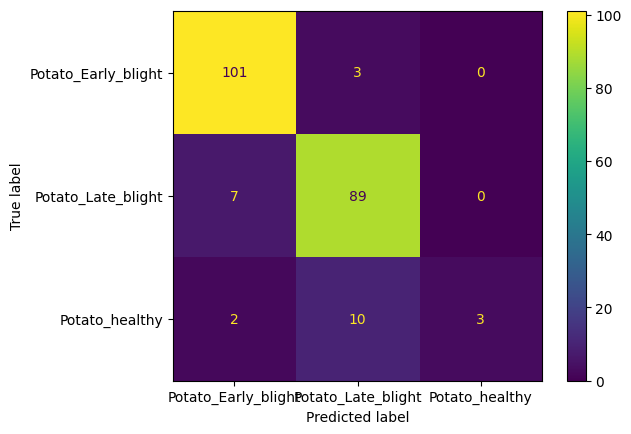

In [ ]:
m5_conf_test = confusion_matrix(y_true=labels_test5, y_pred=pred_test5)
viz = ConfusionMatrixDisplay(m5_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test5, y_pred=pred_test5, average=None)

array([0.94392523, 0.8989899 , 0.33333333])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test5, y_pred=pred_test5, average=None)

array([0.91818182, 0.87254902, 1.        ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test5, y_pred=pred_test5, average=None)

array([0.97115385, 0.92708333, 0.2       ])

We can observe an accuracy of 97%/89%, while e. g. the F1 score still is dangerously low (33.3%)

### Model 6

Now that we see adding another Conv-Conv-Pooling layer was not really helpful, the question is: Do we add yet another one? Or apply another dropout layer after the first application? Since the dropout layer is strategically placed after these layers, there is no harm in starting with adding another iteration first. with the complexity of the model increasing, we should add another epoch to observe the training behaviour further.

In [ ]:
epochs = 6

In [ ]:
model6 = Sequential()
model6.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(Conv2D(16,3,padding="same", activation='relu'))
model6.add(MaxPooling2D())
model6.add(Dropout(0.2))
model6.add(Flatten())
model6.add(Dense(64, activation='relu'))
model6.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,883 (4.05 MB)

 Trainable params: 1,060,883 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit6 = model6.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - SparseCategoricalAccuracy: 0.6012 - loss: 0.8142 - val_SparseCategoricalAccuracy: 0.8512 - val_loss: 0.4310
Epoch 2/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - SparseCategoricalAccuracy: 0.8719 - loss: 0.3399 - val_SparseCategoricalAccuracy: 0.9070 - val_loss: 0.2431
Epoch 3/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - SparseCategoricalAccuracy: 0.9273 - loss: 0.1967 - val_SparseCategoricalAccuracy: 0.9302 - val_loss: 0.1967
Epoch 4/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - SparseCategoricalAccuracy: 0.9509 - loss: 0.1318 - val_SparseCategoricalAccuracy: 0.8698 - val_loss: 0.2878
Epoch 5/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - SparseCategoricalAccuracy: 0.9453 - loss: 0.1520 - val_SparseCategoricalAccuracy: 0.9163 - val_loss: 0.2159
Epoch 6/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - SparseCategoricalAccuracy: 0.9596 - loss: 0.1008 - val_SparseCategoricalAccuracy: 0.9488 - val_loss: 0.0999


In [ ]:
pred_test6 = np.array([])
labels_test6 =  np.array([])
for x, y in img_dataset_test:
  pred_test6 = np.concatenate([pred_test6, np.argmax(model6.predict(x),axis=1)])
  labels_test6 = np.concatenate([labels_test6, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


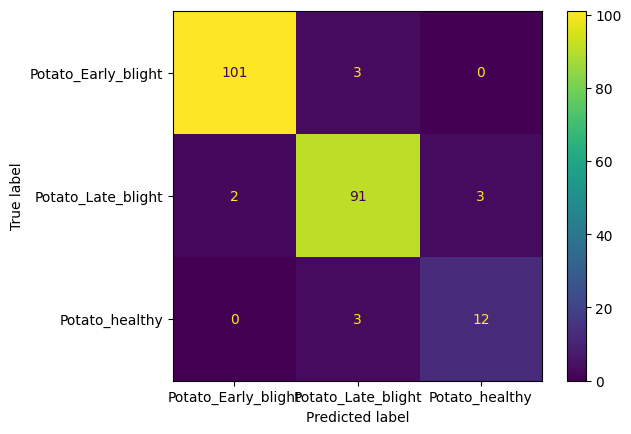

In [ ]:
m6_conf_test = confusion_matrix(y_true=labels_test6, y_pred=pred_test6)
viz = ConfusionMatrixDisplay(m6_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test6, y_pred=pred_test6, average=None)

array([0.97584541, 0.94300518, 0.8       ])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test6, y_pred=pred_test6, average=None)

array([0.98058252, 0.93814433, 0.8       ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test6, y_pred=pred_test6, average=None)

array([0.97115385, 0.94791667, 0.8       ])

That appears to have brought a breakthrough! The accuracy of the model is 95%/96% on the training/testing data, and the F1 score is up to 80%. It appears we have found a suitable model. For a last iteration, let us see what the effects of applying a dropout layer after each Conv-Conv-Pooling layer on the results is!

### Model 7

In [ ]:
model7 = Sequential()
model7.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(MaxPooling2D())
model7.add(Dropout(0.2))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(MaxPooling2D())
model7.add(Dropout(0.2))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(Conv2D(16,3,padding="same", activation='relu'))
model7.add(MaxPooling2D())
model7.add(Dropout(0.2))
model7.add(Flatten())
model7.add(Dense(64, activation='relu'))
model7.add(Dense(3, activation='softmax' )) #Depending on whether we want to predict probabilities, we could also choose: activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,883 (4.05 MB)

 Trainable params: 1,060,883 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit7 = model7.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - SparseCategoricalAccuracy: 0.4889 - loss: 0.9516 - val_SparseCategoricalAccuracy: 0.7953 - val_loss: 0.6285
Epoch 2/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - SparseCategoricalAccuracy: 0.7752 - loss: 0.6031 - val_SparseCategoricalAccuracy: 0.8465 - val_loss: 0.3961
Epoch 3/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - SparseCategoricalAccuracy: 0.8636 - loss: 0.3561 - val_SparseCategoricalAccuracy: 0.9163 - val_loss: 0.2444
Epoch 4/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - SparseCategoricalAccuracy: 0.9264 - loss: 0.2041 - val_SparseCategoricalAccuracy: 0.9256 - val_loss: 0.2344
Epoch 5/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - SparseCategoricalAccuracy: 0.9450 - loss: 0.1442 - val_SparseCategoricalAccuracy: 0.9116 - val_loss: 0.2239
Epoch 6/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - SparseCategoricalAccuracy: 0.9657 - loss: 0.1023 - val_SparseCategoricalAccuracy: 0.9395 - val_loss: 0.1525


In [ ]:
pred_test7 = np.array([])
labels_test7 =  np.array([])
for x, y in img_dataset_test:
  pred_test7 = np.concatenate([pred_test7, np.argmax(model7.predict(x),axis=1)])
  labels_test7 = np.concatenate([labels_test7, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


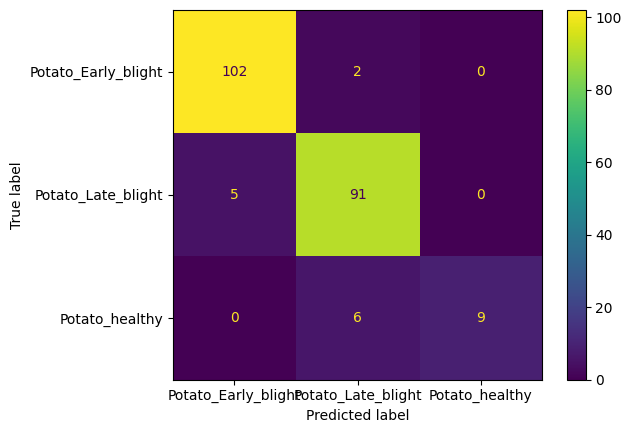

In [ ]:
m7_conf_test = confusion_matrix(y_true=labels_test7, y_pred=pred_test7)
viz = ConfusionMatrixDisplay(m7_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test7, y_pred=pred_test7, average=None)

array([0.96682464, 0.93333333, 0.75      ])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test7, y_pred=pred_test7, average=None)

array([0.95327103, 0.91919192, 1.        ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test7, y_pred=pred_test7, average=None)

array([0.98076923, 0.94791667, 0.6       ])

We do see a slight worsening in the confusion matrix misclassification entries above, induced by the increase in randomness. We'll keep model 6.

## Involutional neural network

To take a model we have not seen in class to go beyond the scope of the lectures, I have chosen to implement an Involutional Neural Network. Involutional networks should be able to address shortcomings of convolutional approaches (such as not taken into account the location of an occurrence in an image - CNN are "spatial-agnostic"). Since the patterns of the diseases on the potato leaf are highly location-specific, and involutional networks are somewhat of an inversion of convolutional networks, implementing one and using it as a benchmark for comparison (without hyperparameter tuning) would be interesting.

As it is outside of the scope of the class, I am not going to built the Involution myself; rather, I will employ an existing Keras example with minimal modification only where necessary.

The following code for the class and implementation is copied/taken from Keras (https://keras.io/examples/vision/involution/, section titled "Involution" and "Involutional Neural Network", respectively) and is **not** my own work:

In [ ]:
class Involution(keras.layers.Layer): # As seen on https://keras.io/examples/vision/involution/
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel


We take the code from the Keras example as cited above. However, the input is adapted to correspond to our 256x256x3 format, and as we only predict on 3 classes, we change the output layer to a dense layer from 64 to 3.

In [ ]:
# Build the involution model. # As seen on https://keras.io/examples/vision/involution/
print("building the involution model...")

inputs = keras.Input(shape=(256, 256, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(3)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(img_dataset_train, epochs=20, validation_data=img_dataset_test)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4298 - loss: 11.2295 - val_accuracy: 0.5070 - val_loss: 3.5025
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6672 - loss: 0.8909 - val_accuracy: 0.5488 - val_loss: 1.2642
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7508 - loss: 0.6767 - val_accuracy: 0.6372 - val_loss: 1.1740
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8256 - loss: 0.4949 - val_accuracy: 0.6186 - val_loss: 1.2075
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9114 - loss: 0.3219 - val_accuracy: 0.6419 - val_loss: 1.4689
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9531 - loss: 0.1921 - val_accuracy: 0.6000 - val_loss: 1.8250
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9773 - loss: 0.0903 - val_accuracy: 0.6093 - val_loss: 2.4800
Epoch 8/20
81/81 ━━━━

In [ ]:
inv_model.summary()

Model: "inv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_1 (Involution)                   │ [(None, 256, 256, 3),       │              26 │
│                                      │ (None, 256, 256, 9, 1, 1)]  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_19 (ReLU)                      │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_2 (Involution)                   │ [(None, 128, 128, 3),       │              26 │
│                                      │ (None, 128, 128, 9, 1, 1)]  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_21 (ReLU)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_3 (Involution)                   │ [(None, 64, 64, 3), (None,  │              26 │
│                                      │ 64, 64, 9, 1, 1)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_23 (ReLU)                      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │         786,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,360,297 (9.00 MB)

 Trainable params: 786,763 (3.00 MB)

 Non-trainable params: 6 (24.00 B)

 Optimizer params: 1,573,528 (6.00 MB)

Now, we can predict our testing data set as done for our self-constructed models earlier:

In [ ]:
pred_test_inv = np.array([])
labels_test_inv =  np.array([])
for x, y in img_dataset_test:
  pred_test_inv = np.concatenate([pred_test_inv, np.argmax(inv_model.predict(x),axis=1)])
  labels_test_inv = np.concatenate([labels_test_inv, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


And similarly, the confusion matrix, here only for the testing data, can be constructed similarly:

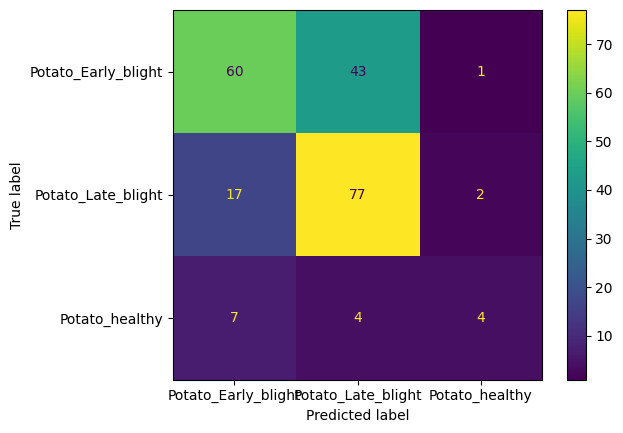

In [ ]:
m_inv_conf_test = confusion_matrix(y_true=labels_test_inv, y_pred=pred_test_inv)
viz = ConfusionMatrixDisplay(m_inv_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

array([0.63829787, 0.7       , 0.36363636])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

array([0.71428571, 0.62096774, 0.57142857])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

array([0.57692308, 0.80208333, 0.26666667])

Just looking at the F1 scores for each category, we see that already both diseases well distinguished by our conv-conv-pooling model are confused quite often (with F-scores of 63.8% and 70.0%, respectively). The healthy potato plants are even scoring worse (F1-score of 36.4%).

At least without further fine and hyperparameter tuning, this Involutional Neural Network is outperformed by our chosen model 6.

We perform a quick check whether the model also profits from a softmax activation function!

In [ ]:
# Build the involution model. # As seen on https://keras.io/examples/vision/involution/
print("building the involution model...")

inputs = keras.Input(shape=(256, 256, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="softmax")(x)
outputs = keras.layers.Dense(3)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(img_dataset_train, epochs=20, validation_data=img_dataset_test)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 564ms/step - accuracy: 0.4385 - loss: 1.0307 - val_accuracy: 0.4465 - val_loss: 0.9780
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4699 - loss: 0.9756 - val_accuracy: 0.4465 - val_loss: 0.9503
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4602 - loss: 0.9502 - val_accuracy: 0.4465 - val_loss: 0.9323
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4682 - loss: 0.9401 - val_accuracy: 0.4465 - val_loss: 0.9208
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4589 - loss: 0.9305 - val_accuracy: 0.4465 - val_loss: 0.9132
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4529 - loss: 0.9281 - val_accuracy: 0.4465 - val_loss: 0.9081
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4577 - loss: 0.9211 - val_accuracy: 0.4465 - val_loss: 0.9048
Epoch 8/20
81/81 ━━━

In [ ]:
pred_test_inv = np.array([])
labels_test_inv =  np.array([])
for x, y in img_dataset_test:
  pred_test_inv = np.concatenate([pred_test_inv, np.argmax(inv_model.predict(x),axis=1)])
  labels_test_inv = np.concatenate([labels_test_inv, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


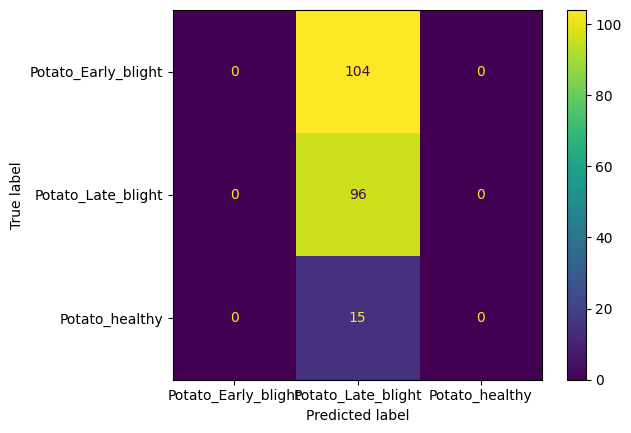

In [ ]:
m_inv_conf_test = confusion_matrix(y_true=labels_test_inv, y_pred=pred_test_inv)
viz = ConfusionMatrixDisplay(m_inv_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

array([0.        , 0.61736334, 0.        ])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([0.        , 0.44651163, 0.        ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test_inv, y_pred=pred_test_inv, average=None)

array([0., 1., 0.])

That is even worse and shows that merely using the softmax activation function was not the reason the classifier performs so badly.

## Comparison with another model

With images and Neural Networks, it is difficult to find another model for comparison not being a neural network. One could apply some filtering/averaging techniques to the images and calculate region values for the pixels to reduce the image complexity (and accomodate for inversions and other variations in the images), and then try to see whether e. g. a GAM (Generalized additive model) can show that pixel region information has enough predicitve potential for our classification problem.
However, with comparison models, we usually want to take a proven reference for benchmarking. As such, we create a rather simplistic NN merely by flattening our data and running it through a dense layer - and see whether it performs as good as our models identified above.

In [ ]:
epochs = 10

In [ ]:
model_ref = Sequential()
model_ref.add(Rescaling(1./255, input_shape=(256, 256, 3)))
model_ref.add(Flatten())
model_ref.add(Dense(64, activation='relu'))
model_ref.add(Dense(3, activation='softmax' ))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_ref.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │      12,582,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,583,171 (48.00 MB)

 Trainable params: 12,583,171 (48.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_ref.compile(
    optimizer ="adam",
    loss = "SparseCategoricalCrossentropy",
    metrics=["SparseCategoricalAccuracy"])

In [ ]:
modelfit_ref = model_ref.fit(
    img_dataset_train,
    validation_data = img_dataset_test,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = epochs)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - SparseCategoricalAccuracy: 0.5516 - loss: 32.2560 - val_SparseCategoricalAccuracy: 0.7721 - val_loss: 0.7036
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - SparseCategoricalAccuracy: 0.7478 - loss: 1.1415 - val_SparseCategoricalAccuracy: 0.7488 - val_loss: 1.0504
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - SparseCategoricalAccuracy: 0.7828 - loss: 0.8799 - val_SparseCategoricalAccuracy: 0.7953 - val_loss: 0.5557
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - SparseCategoricalAccuracy: 0.8040 - loss: 0.6353 - val_SparseCategoricalAccuracy: 0.7814 - val_loss: 1.4461
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - SparseCategoricalAccuracy: 0.7686 - loss: 1.0510 - val_SparseCategoricalAccuracy: 0.8233 - val_loss: 0.4572
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - SparseCategoricalAccuracy: 0.8003 - loss: 0.6878 - val_SparseCategoricalAccuracy: 0.7721 - val_loss: 0.6996
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━

In [ ]:
pred_train_ref = np.array([])
labels_train_ref =  np.array([])
for x, y in img_dataset_train:
  pred_train_ref = np.concatenate([pred_train_ref, np.argmax(model_ref.predict(x),axis=1)])
  labels_train_ref = np.concatenate([labels_train_ref, y.numpy()])

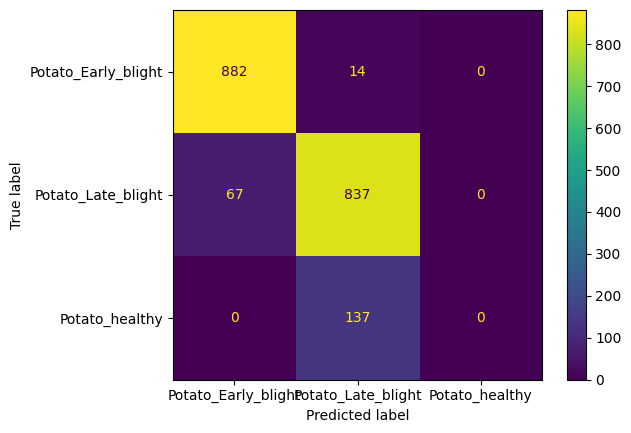

In [ ]:
m_ref_conf_train = confusion_matrix(y_true=labels_train_ref, y_pred=pred_train_ref)
viz = ConfusionMatrixDisplay(m_ref_conf_train, display_labels = class_names)
viz.plot()

In [ ]:
pred_test_ref = np.array([])
labels_test_ref =  np.array([])
for x, y in img_dataset_test:
  pred_test_ref = np.concatenate([pred_test_ref, np.argmax(model_ref.predict(x),axis=1)])
  labels_test_ref = np.concatenate([labels_test_ref, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


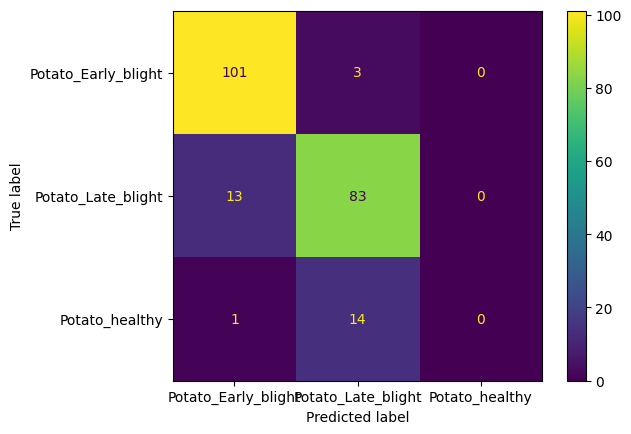

In [ ]:
m_ref_conf_test = confusion_matrix(y_true=labels_test_ref, y_pred=pred_test_ref)
viz = ConfusionMatrixDisplay(m_ref_conf_test, display_labels = class_names)
viz.plot()

In [ ]:
sklearn.metrics.f1_score(y_true=labels_test_ref, y_pred=pred_test_ref, average=None)

array([0.92237443, 0.84693878, 0.        ])

In [ ]:
sklearn.metrics.precision_score(y_true=labels_test_ref, y_pred=pred_test_ref, average=None)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([0.87826087, 0.83      , 0.        ])

In [ ]:
sklearn.metrics.recall_score(y_true=labels_test_ref, y_pred=pred_test_ref, average=None)

array([0.97115385, 0.86458333, 0.        ])

So, from the above, we can see that training and (!) validation accuracy peak both around 86% (at different epochs), with the last epoch yielding 83% and 86% of training and validation accuracy. We do not observe overfitting effects from the epoch-wise accuracy results.
When looking at the train or validation data metrics, we do see that none of the healthy images are flagged as healthy, but rather are all flagged as FPs (almost exclusively LB in either train or validation data set).

As such, compared to a baseline model, we have created a model that at least achieves 80% F1 score. Also from an accuracy point of view, model 6 achieves 96%/95% on the training and validation data. As such, our model is definitely an improvement to a naive baseline model.

# Summary

## What went well

We have successfully created a multi-classification model that is able to distinguish between images of potato leaves affected by either of early or late blight or not affected by either disease. By introducing drop-out layers and settling for a reiteration of Conv-Conv-Pooling layers, the chosen model (model 6) achieves an accuracy of 96% and 95% on the training and validation data, respectively, while maintaining a respectable 80% F1 score for the healthy class.
To illustrate that an naive approach would overfit by disregarding the relatively low number of healthy leaf images provided, we fed the preprocessed data into a single deep layer, which (depending on the epoch size) could not rise beyond 86% in accuracy and misclassified all healthy leaf images. This reference model also shows that single pixel image information is not sufficient for extracting reasonable features corresponding to the specific early/late blight pattern, which is picked up by the Conv-Conv-Pooling layers.

## What could have gone better

We should keep in mind that 80% of an F1 score is only relatively good - and with only 15 (!) images in the validation set, the score might well be the result of randomness during training.

## Potential future work

If one has the resources (read: access to GPUs or sufficient time to run this on 'free' CPU time), the first concern should be to tackle randomness effects: One could use cross-validation (e. g. k-fold) to ensure that the models actually produce less bias towards early/late blight.
After doing that, one could see whether the models could be further fine-tuned, so to even better pick up on late or early blight image features. The first option that comes to mind would be to further adjust the number of filters and kernels. Another would be to consider other pooling layers (such as AveragePooling2D).
It would also be interesting to expand the data set to include other objects affecting potato leaves, such as mites or bigger critters (e. g. potato beetles). It is reasonable to assume the model would train well on small animals having clustering behaviours or bigger beetles, but how it would perform for animals populating a leave in a more distributed manner (so to appear like a texture applied uniformly on the leaf) is uncertain.
To go beyond the scope of the lectures, another model suitable for image feature analysis could also be implemented: Either a GNN (Graph Neural Network) or a Capsule Neural Network, with the latter clearly being beneficial to the detection of geometric features, such as particularly characteristic so-called "bulls-eyes" occurring in early blight.